In [1]:
from keras.applications import VGG16
from keras.utils.vis_utils import plot_model

vgg16 = VGG16(weights="imagenet")


def plot_verbose(model, to_file: str):
    plot_model(
        model=model,
        to_file=to_file,
        show_shapes=True, 
        show_layer_names=True,
        show_layer_activations=True,
        show_trainable=True,
    )

plot_verbose(vgg16, "model_plots/vgg16.png")

print(vgg16.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [2]:
import keras

X_l1 = vgg16.get_layer("block1_conv2").output
X_l2 = vgg16.get_layer("block2_conv2").output
X_l3 = vgg16.get_layer("block3_conv3").output

model_l1 = keras.Model(inputs=vgg16.input, outputs=X_l1)
model_l2 = keras.Model(inputs=vgg16.input, outputs=X_l2)
model_l3 = keras.Model(inputs=vgg16.input, outputs=X_l3)


plot_verbose(model_l1, "model_plots/model_l1.png")
plot_verbose(model_l2, "model_plots/model_l2.png")
plot_verbose(model_l3, "model_plots/model_l3.png")

from keras import layers

X_l1_resized = layers.AveragePooling2D(pool_size=(2,2))(X_l1)

X_l1_double = layers.concatenate([X_l1_resized, X_l1_resized])


x = layers.add([X_l1_double, X_l2])

m = keras.Model(inputs=vgg16.input, outputs=x)

plot_verbose(m, "weird.png")

In [130]:
import tensorflow as tf
import keras
from keras import layers

class AttentionGlobalContext(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionGlobalContext, self).__init__(**kwargs)
        self.correlation_matrix = None

    def build(self, input_shape):
        # input_shape = (batch_size, width, height, channels)
        channels = input_shape[-1]
        self.correlation_matrix = self.add_weight(
            name="correlation_matrix",
            shape=(channels, channels),
            initializer="identity",  # choose an appropriate initializer
            trainable=True,
        )

    def call(self, inputs):
        # Assume inputs is an image with shape = (batch_size, width, height, channels)
        batch_size = tf.shape(inputs)[0]
        width = tf.shape(inputs)[1]
        height = tf.shape(inputs)[2]
        channels = tf.shape(inputs)[3]

        # Reshape inputs to treat width and height as a single sequence dimension
        # inputs shape after reshape: (batch_size, width*height, channels)
        inputs = tf.reshape(inputs, (batch_size, width*height, channels))
        tf.print('Inputs shape after reshape:', inputs.shape)

        # Reshape inputs for broadcasting
        # xi and xj shape: (batch_size, width*height, 1, channels) and (batch_size, 1, width*height, channels) respectively
        xi = tf.reshape(inputs, (batch_size, width*height, 1, channels))
        xj = tf.reshape(inputs, (batch_size, 1, width*height, channels))
        tf.print('xi and xj shape:', xi.shape, xj.shape)

        # Compute all rij simultaneously using broadcasting
        # rij shape: (batch_size, width*height, width*height)
        rij = tf.linalg.matvec(tf.linalg.matvec(self.correlation_matrix, xi, transpose_a=True), xj)
        rij = tf.squeeze(rij, axis=-1)  # remove last dimension
        tf.print('rij shape:', rij.shape)

        # Apply softmax to rij to get attention scores
        # attention_scores shape: (batch_size, width*height, width*height)
        # attention_scores = tf.nn.softmax(rij, axis=-1)
        # tf.print('attention_scores shape:', attention_scores.shape)

        # tf.print('attention_scores[..., None] shape', attention_scores[..., None].shape)

        # Compute global context
        # global_context shape before reshaping: (batch_size, width*height, channels)
        global_context = tf.reduce_sum(rij[..., None] * xj, axis=1)  # apply attention_scores to each xj and sum

        # divide by width*height to make sure the magnitude of global context does not explode
        global_context = tf.divide(global_context, tf.cast(width*height, tf.float32))

        tf.print('global_context shape before reshaping:', global_context.shape)

        # Reshape global context back to original shape
        # global_context shape after reshaping: (batch_size, width, height, channels)
        global_context = tf.reshape(global_context, (batch_size, width, height, channels))
        tf.print('global_context shape after reshaping:', global_context.shape)

        return global_context




(None, 56, 56)
Inputs shape after reshape: TensorShape([None, 3136, 256])
xi and xj shape: TensorShape([None, 3136, 1, 256]) TensorShape([None, 1, 3136, 256])
rij shape: TensorShape([None, None, 3136])
global_context shape before reshaping: TensorShape([None, 3136, 256])
global_context shape after reshaping: TensorShape([None, 56, 56, 256])
1/1 [==============================] - 0s 146ms/step


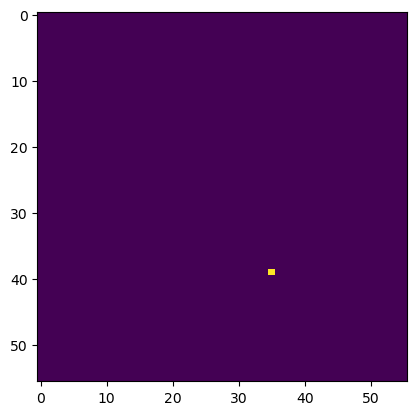

0.0 1.0


In [178]:
C_l1 = AttentionGlobalContext()(X_l3)

M_l1 = layers.add([C_l1, X_l3])

# apply a convolution of shape C x 3 x 3 x 1 where C is the number of channels
T_l1 = layers.Conv2D(1, 3, activation='relu', padding='same')(M_l1)

# reshape to get a 1D vector of length W*H
T_l1 = layers.Reshape((-1,))(T_l1)

# normalize to get a probability distribution
S_l1 = layers.Activation('softmax')(T_l1)


# softmax across the width and height dimensions
# S_l1 = layers.Softmax()(T_l1)

# # reshape to get back to the original shape
S_l1 = layers.Reshape((56, 56))(S_l1)

print(S_l1.shape)

m = keras.Model(inputs=vgg16.input, outputs=S_l1)

img_path = 'images/highway.jpeg'

from tensorflow.keras.preprocessing import image
import numpy as np
from keras.applications.vgg16 import preprocess_input

import matplotlib.pyplot as plt

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = m.predict(x)

plt.imshow(preds[0,:, :])
plt.show()

# min max
print(preds.min(), preds.max())


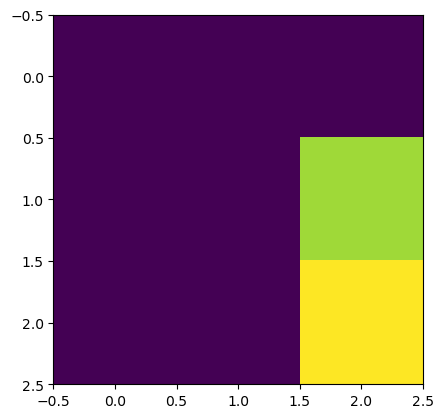

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]


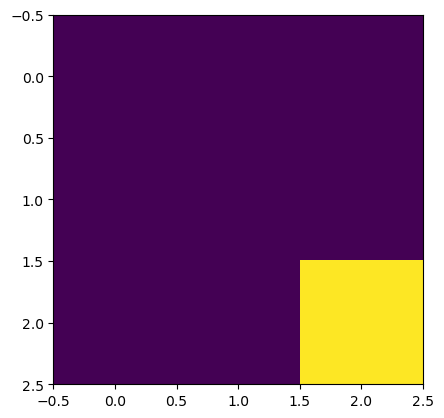

In [144]:
inp = np.array([[1., 2., 3.], [4., 5., 60000.], [7., 8., 70000.]])
plt.imshow(inp)
plt.show()

layer = layers.Softmax([0, 1])
res = layer(inp).numpy()

print(res)

plt.imshow(res)
plt.show()